# Lap Efficiency Correlation Report

Date: November 21, 2024

Authors: Tamzeed Quazi, Jonah Lee

## Overview

Following our participation in the Formula Sun Grand Prix in July 2024, we present an analysis the factors correlating to our efficiency throughout the race.

Our primary metric for efficiency is **lap energy**, which has units of Joules and describes the net (i.e. accounting for regen) electrical power consumed by the motor during one lap at the 5.07km NCM Motorsports Park track.



## Imports

In [121]:
from data_tools.collections import TimeSeries
from data_tools.query import DBClient
from data_tools.collections import FSGPDayLaps
import datetime
import numpy as np
import pandas as pd

from numba.cpython.randomimpl import seed_impl
from numpy import ndarray

# Plotting
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Open Meteo API
import openmeteo_requests
import requests_cache
from retry_requests import retry

FSGP_TRACK_LEN_M = 5_070

driver_colours = {
    "Alex": "red",
    "Bryan": "orange",
    "Diego": "green",
    "Phoebe": "blue"
}

data_client = DBClient("can_log_prod")

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


## Load Data

See [add link here](./link_to_local_file) for querying and derivation of data. Since this querying requires a connection to our UBC Solar Tailnet and takes a few minutes, we have stored our derived data for this analysis in a csv file \[link?\].

In [122]:
df = pd.read_csv("../lap_data.csv")
df.head(10)

,lap_distance_(m),energy_total_(J),energy_regen_(J),speed_variance_(mph^2),motor_power_variance_(W^2),motor_current_variance_(A^2),acceleration_variance_(m^2/s^4),accelerator_variance,acceleration_avg_(m/s^2),battery_temp_avg_(C),pack_current_avg_(A),driver,speed_avg_(mph),lap_start_time,lap_end_time,day,efficiency_practical_(J/m),efficiency_real_(J/m)
0,5422.621218,845440.759250,19444.581795,10.706944,4.299373e+06,285.122210,0.003677,1330.364989,0.002039,29.816664,15.096574,Diego,26.745,2024-07-16 15:00:00+00:00,2024-07-16 15:07:04+00:00,1,166.753601,155.909979
1,5110.366020,742762.677311,24433.210032,2.699048,4.754985e+06,318.214644,0.003228,1492.935963,-0.000130,30.666005,15.107015,Diego,31.068,2024-07-16 15:07:04+00:00,2024-07-16 15:13:09+00:00,1,146.501514,145.344321
2,5090.330928,622935.357656,8203.242310,1.182816,1.788749e+06,118.544287,0.001757,575.607814,-0.000127,31.000000,10.042580,Diego,26.372,2024-07-16 15:13:09+00:00,2024-07-16 15:20:19+00:00,1,122.866934,122.376200
3,5171.397776,628939.849032,5167.430689,1.897055,2.097405e+06,140.488556,0.002137,706.120444,0.000103,31.618644,10.421670,Diego,26.872,2024-07-16 15:20:19+00:00,2024-07-16 15:27:21+00:00,1,124.051252,121.618927
4,5116.421189,632982.270880,1826.344625,1.927264,2.787216e+06,189.245535,0.002160,893.573462,-0.000276,32.000000,10.687180,Diego,28.492,2024-07-16 15:27:21+00:00,2024-07-16 15:33:59+00:00,1,124.848574,123.715825
5,5147.460343,650760.347944,2754.900281,1.752659,2.993137e+06,205.296704,0.002312,942.051720,0.000038,32.211091,11.190644,Diego,29.686,2024-07-16 15:33:59+00:00,2024-07-16 15:40:21+00:00,1,128.355098,126.423577
6,5269.859661,665763.351505,2868.443349,9.733535,2.921008e+06,200.933250,0.002285,981.239839,-0.000078,33.000000,9.809870,Diego,25.541,2024-07-16 15:40:21+00:00,2024-07-16 15:47:45+00:00,1,131.314271,126.334171
7,5151.753050,650773.678031,6558.633813,1.587772,2.751867e+06,191.864322,0.002384,890.992444,0.000063,32.498828,11.374014,Diego,29.455,2024-07-16 15:47:45+00:00,2024-07-16 15:54:10+00:00,1,128.357727,126.320822
8,5106.233113,627637.125102,8121.477653,1.341076,2.897804e+06,205.418751,0.002357,969.874765,-0.000081,32.000000,11.014715,Diego,29.152,2024-07-16 15:54:10+00:00,2024-07-16 16:00:39+00:00,1,123.794305,122.915878
9,5152.105993,668908.144054,8188.121412,1.224626,3.412304e+06,246.431553,0.002805,1195.662138,0.000149,32.000000,12.117389,Diego,29.378,2024-07-16 16:00:39+00:00,2024-07-16 16:07:05+00:00,1,131.934545,129.831984


In [123]:
distance_filter = np.logical_and(df["lap_distance_(m)"] > 5000, df["lap_distance_(m)"] < 5200)
filtered_df = df[distance_filter]

## Results

The below function simplifies plotting correlation. We then analyze several factors that we believe may have a correlation with lap energy

In [124]:
def plot_relationship(df, feature_col, target_col='energy_total_(J)', poly_degree=2, color_by_driver=False, show_fit=True):
    """
    Plot the relationship between a feature and the target variable.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    feature_col (str): Name of the feature column
    target_col (str): Name of the target column
    poly_degree (int): Degree of polynomial fit (default: 2)
    color_by_driver (bool): If True, points will be colored by driver (default: False)
    show_fit (bool): If True, shows polynomial fit line (default: True)
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    plt.figure(figsize=(12, 6))
    
    # Convert datetime to numbers for plotting if necessary
    if pd.api.types.is_datetime64_any_dtype(df[feature_col]):
        x = mdates.date2num(df[feature_col])
        is_datetime = True
    else:
        x = df[feature_col].values
        is_datetime = False
    
    y = df[target_col].values
    
    if color_by_driver and 'driver' in df.columns:
        # Plot points for each driver with their assigned color
        for driver, color in driver_colours.items():
            mask = df['driver'] == driver
            if mask.any():  # Only plot if driver exists in the data
                plt.scatter(df[feature_col][mask], y[mask], alpha=0.5, color=color, label=driver)
    else:
        # Original single-color scatter plot
        plt.scatter(df[feature_col], y, alpha=0.5)
    
    if show_fit and not is_datetime:  # Only show fit for non-datetime x values
        # Fit polynomial regression
        x_reshape = x.reshape(-1, 1)
        poly_features = PolynomialFeatures(degree=poly_degree)
        x_poly = poly_features.fit_transform(x_reshape)
        model = LinearRegression()
        model.fit(x_poly, y)
        
        # Sort points for smooth curve
        sort_idx = np.argsort(x.ravel())
        x_sorted = x_reshape[sort_idx]
        y_pred = model.predict(poly_features.transform(x_sorted))
        
        plt.plot(x_sorted, y_pred, 'r--', label='Polynomial fit')
    
    plt.xlabel(feature_col)
    plt.ylabel(target_col)
    plt.title(f'Relationship between {feature_col} and {target_col}')
    
    if is_datetime:
        # Format datetime axis
        plt.gcf().autofmt_xdate()  
    
    plt.legend()
    plt.grid(True)
    plt.show()

## Speed Factors

### Average Speed
From the average speed plot we see that there seems to be a quadratic relationship between lap energy usage / efficiency and the average speed of a race. The ideal speed to drive that maximized efficiency seems to be around 20 mph. 

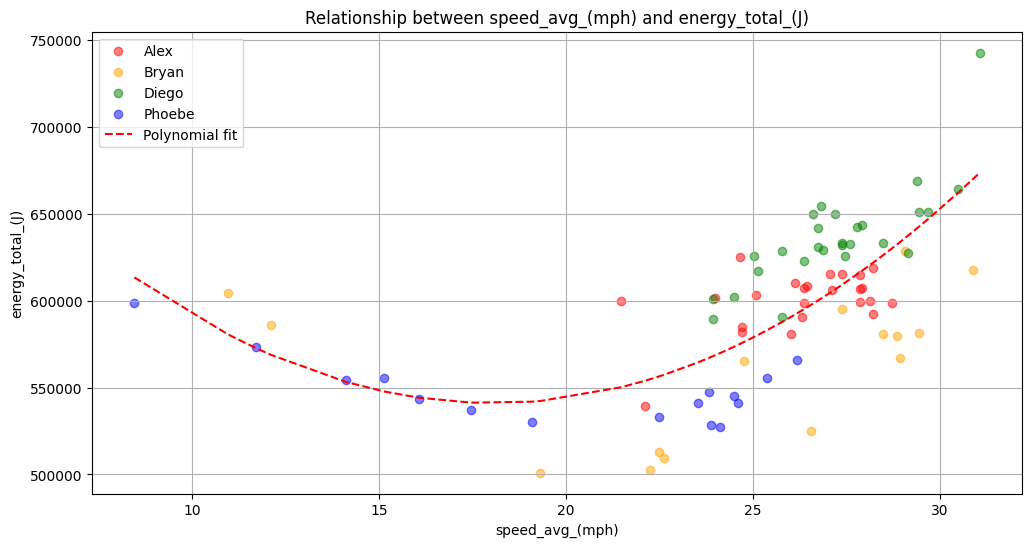

In [125]:
plot_relationship(filtered_df, "speed_avg_(mph)", poly_degree=2, color_by_driver=True)

Below we also have the speed variance per lap. There aren't any clear trends to correlate minimizing speed variance with maximizing efficiency

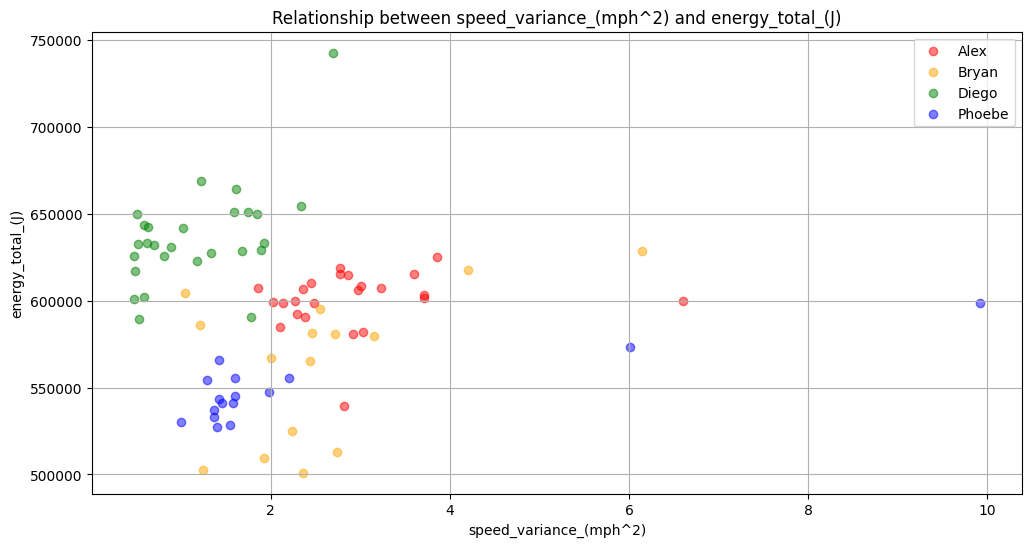

In [126]:
plot_relationship(filtered_df, "speed_variance_(mph^2)", show_fit=False, color_by_driver=True)

## Battery and Motor

### Average Battery Temperature

From the average batter temperature plots, we don't see much of a correlation between it and efficiency but we do get an idea of how the batter warms throughout a raceday. 

C:\Users\tamze\AppData\Local\Temp\ipykernel_9276\734103949.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


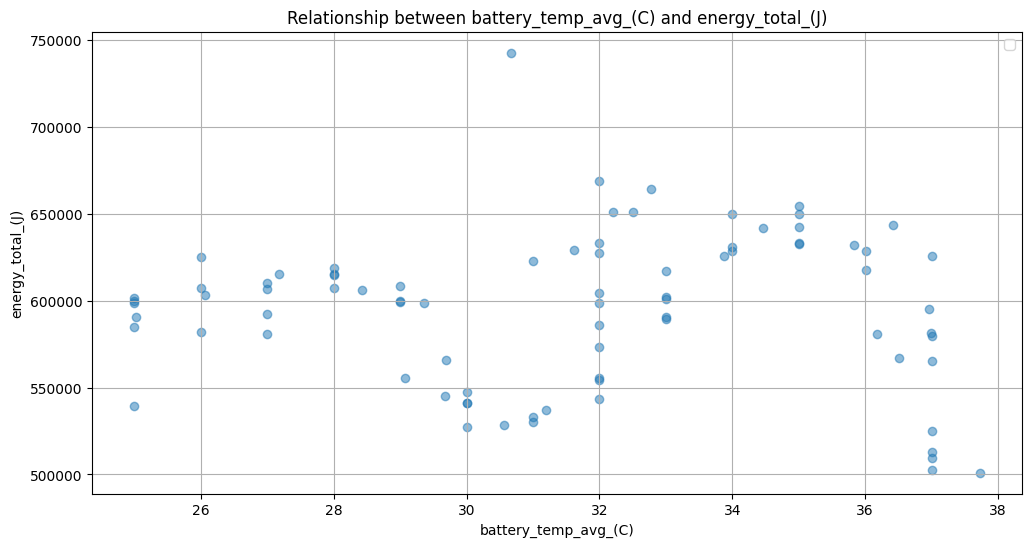

In [127]:
plot_relationship(filtered_df, "battery_temp_avg_(C)", show_fit=False)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


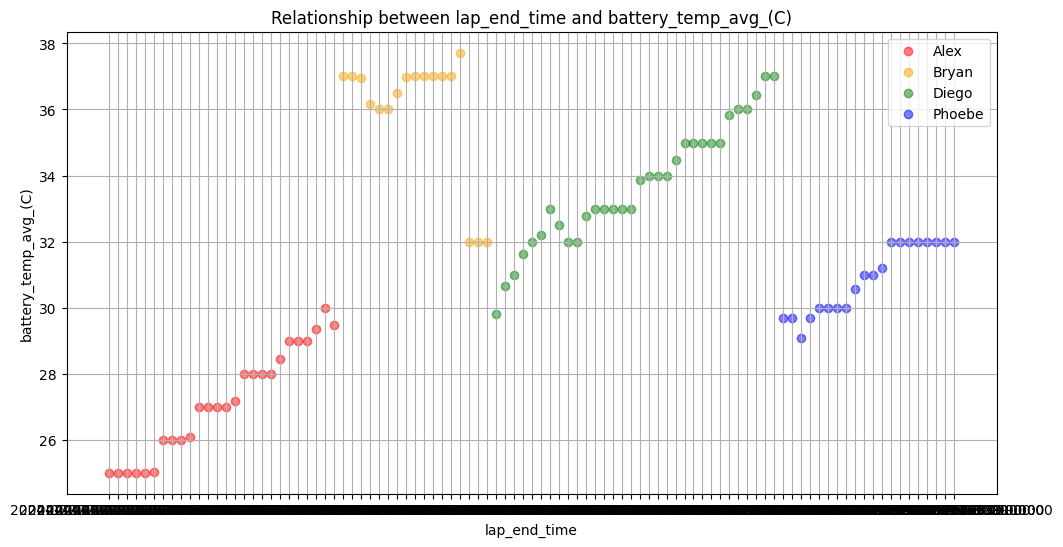

In [128]:
plot_relationship(df, target_col="battery_temp_avg_(C)", feature_col="lap_end_time", show_fit=False, color_by_driver=True)

Below are plots to show how our power/current draw from our motor and battery relates to our total energy usage.

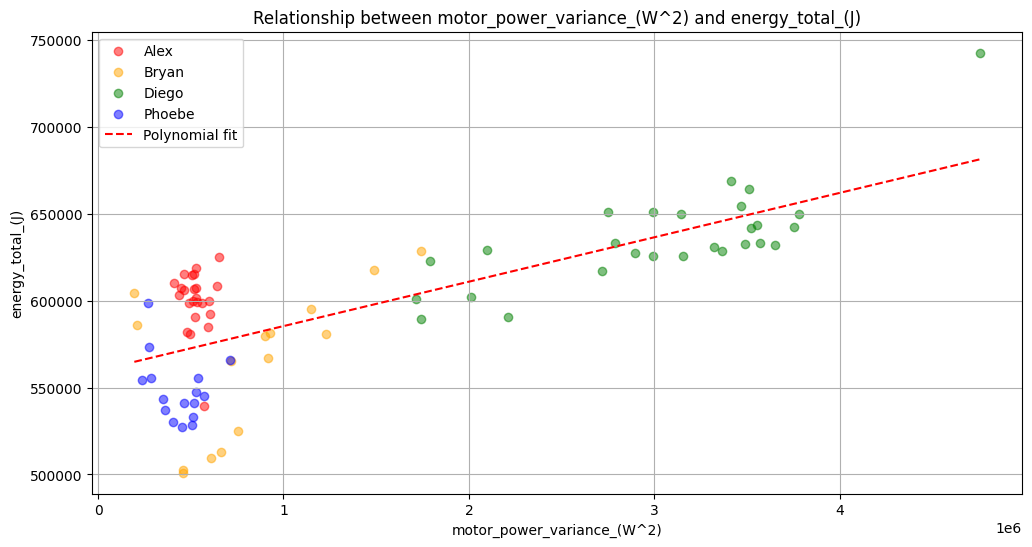

In [129]:
plot_relationship(filtered_df, feature_col="motor_power_variance_(W^2)", poly_degree=1, color_by_driver=True)

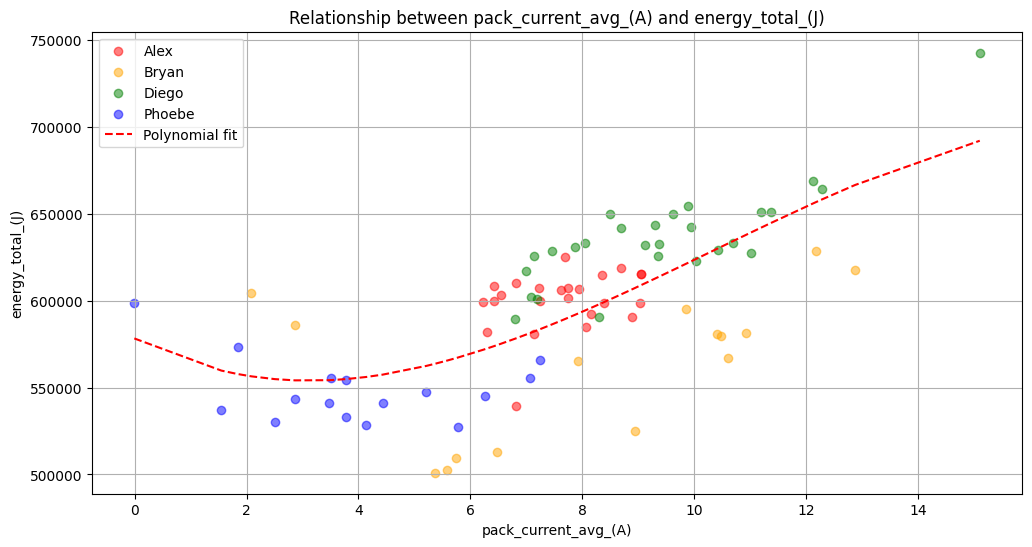

In [130]:
plot_relationship(filtered_df, "pack_current_avg_(A)", poly_degree=3, color_by_driver=True)

## Accelerator

Below are plots that relate how the driver steps on the accelerator with what happens in the rest of the car

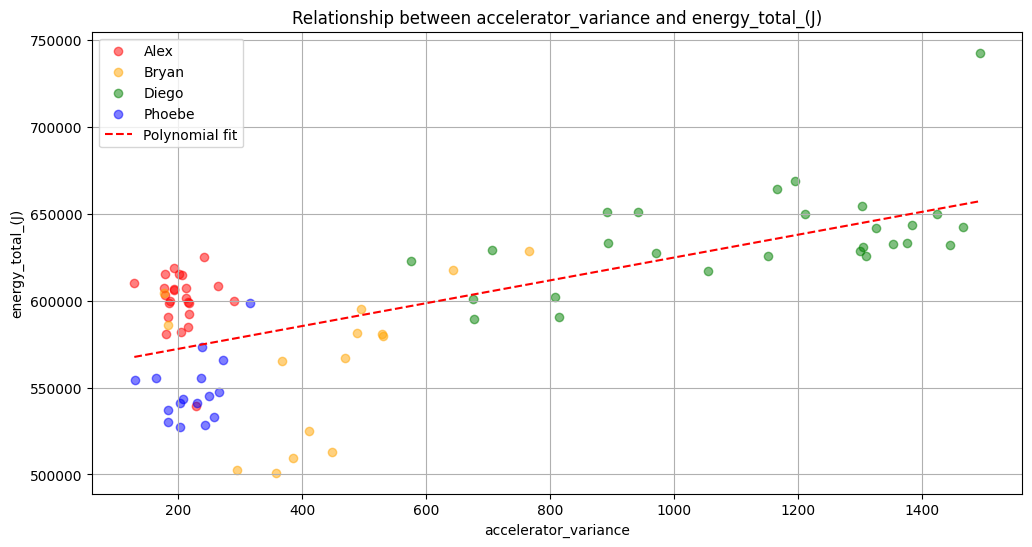

In [131]:
plot_relationship(filtered_df, feature_col="accelerator_variance", poly_degree=1, color_by_driver=True)

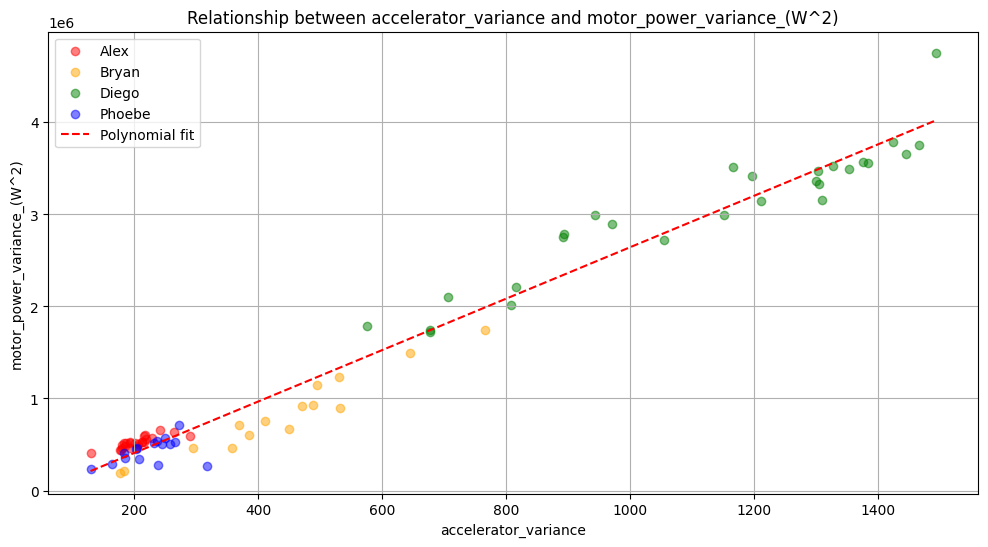

In [132]:
plot_relationship(filtered_df, feature_col="accelerator_variance", target_col="motor_power_variance_(W^2)", poly_degree=1, color_by_driver=True)

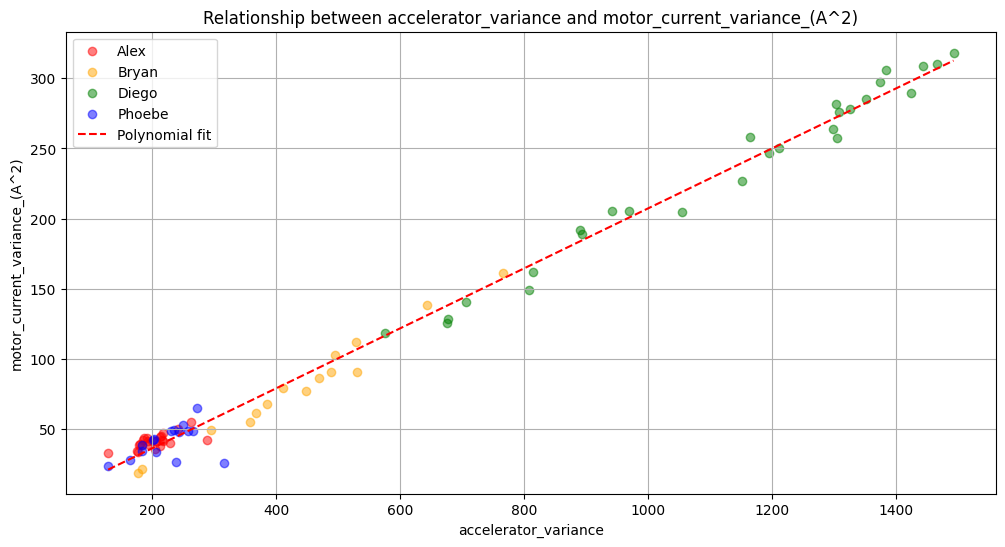

In [133]:
plot_relationship(filtered_df, feature_col="accelerator_variance", target_col="motor_current_variance_(A^2)", poly_degree=1, color_by_driver=True)

## Distance 
Below is a plot of the actual distance traveled by the car to complete a lap. It suggests a linear trend and intuitive trend that by travelling less of a distance would also reduce energy usage. This suggests that otpimizing race lines can be a good strategy.

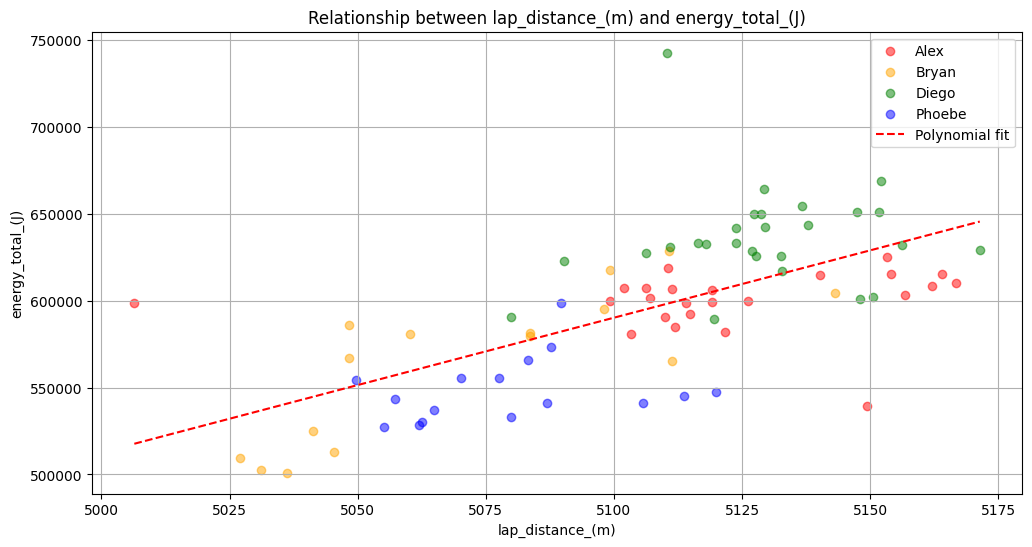

In [134]:
plot_relationship(filtered_df, feature_col="lap_distance_(m)", poly_degree=1, color_by_driver=True)

## Regen

From a regened energy plot alone, we don't see a direct trend with efficiency, but it seems that regen with a specific driver style may optimize efficiency.

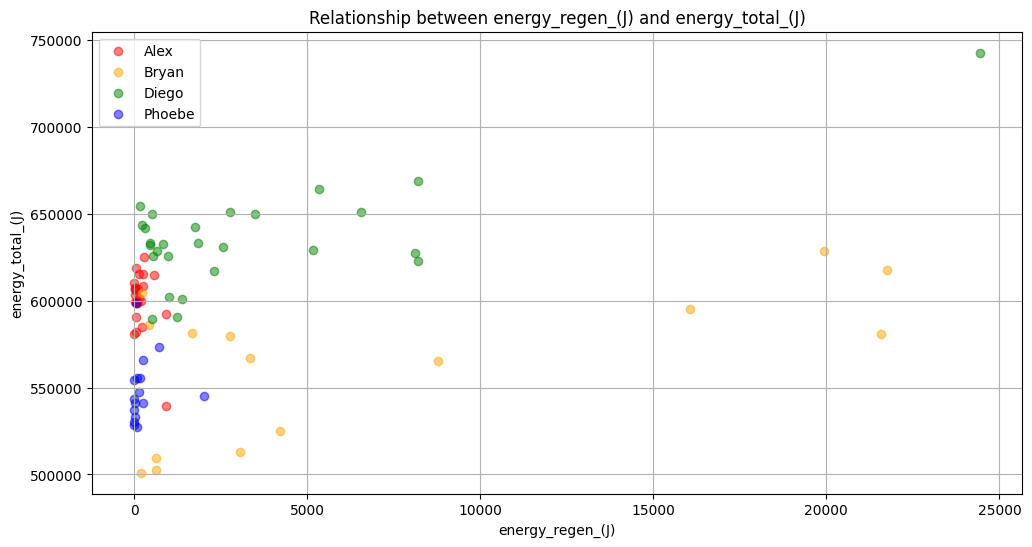

In [135]:
plot_relationship(filtered_df, "energy_regen_(J)", show_fit=False, color_by_driver=True)

## Wind

TODO - FIX

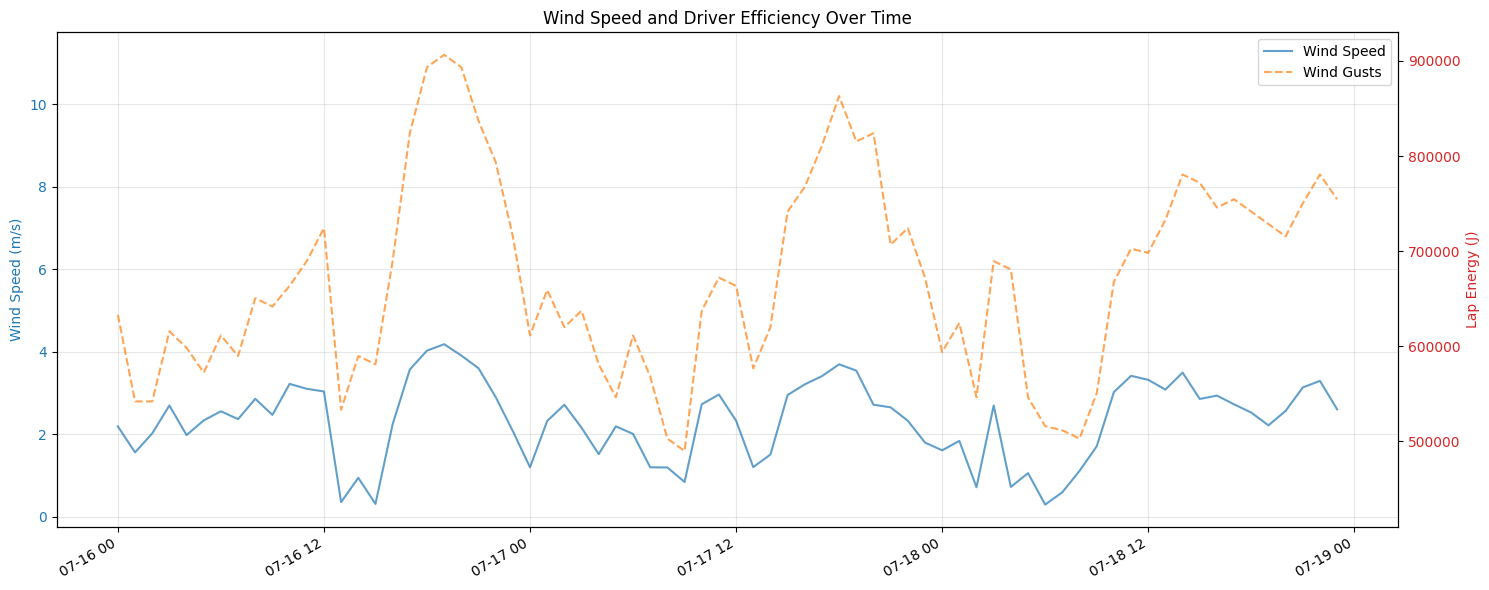

In [136]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def fetch_wind_data(latitude, longitude, start_date, end_date):
    """
    Fetch hourly wind speed data from Open-Meteo API
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["wind_speed_10m", "wind_gusts_10m"],
        "wind_speed_unit": "ms"  # Using m/s for scientific analysis
    }
    
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
    
    # Process hourly data
    hourly = response.Hourly()
    hourly_data = {
        "date": pd.date_range(
            start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
            end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
            freq = pd.Timedelta(seconds = hourly.Interval()),
            inclusive = "left"
        ),
        "wind_speed": hourly.Variables(0).ValuesAsNumpy(),
        "wind_gusts": hourly.Variables(1).ValuesAsNumpy(),
    }
    
    return pd.DataFrame(data = hourly_data)

def plot_wind_analysis(df, lap_end_times, lap_efficiencies, lap_drivers):
    """
    Create a combined plot of wind data and driver efficiencies using lap end times.
    """
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plot wind data on primary y-axis (left)
    ax1.plot(df['date'], df['wind_speed'], label='Wind Speed', color='tab:blue', alpha=0.7)
    ax1.plot(df['date'], df['wind_gusts'], label='Wind Gusts', color='tab:orange', linestyle='--', alpha=0.7)
    ax1.set_ylabel('Wind Speed (m/s)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)

    # Set up secondary y-axis for lap efficiencies (right)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Lap Energy (J)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Set y-axis limits to fit lap_efficiencies data range
    if not lap_efficiencies.empty:
        ax2.set_ylim([lap_efficiencies.min() * 0.9, lap_efficiencies.max() * 1.1])

    # Plot each driver's efficiencies on secondary y-axis using lap end times
    for driver, color in driver_colours.items():
        mask = np.array(lap_drivers) == driver
        if np.any(mask):
            ax2.scatter(
                lap_end_times[mask],
                lap_efficiencies[mask],
                color=color,
                label=f"Driver: {driver}",
                alpha=1,
                s=50  # Increase marker size for visibility
            )
    
    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    # Format x-axis to show dates nicely
    plt.title('Wind Speed and Driver Efficiency Over Time')
    plt.xlabel('Lap End Time')
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

# lat lon for center of track
latitude = 37.00272354871939
longitude = -86.36671627935802
start_date = "2024-07-16"  # FSGP Day 1
end_date = "2024-07-18"    # FSGP Day 3

wind_df = fetch_wind_data(latitude, longitude, start_date, end_date)
plot_wind_analysis(wind_df, df["lap_end_time"], df["energy_total_(J)"], lap_drivers=driver_colours)